In [131]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'1.13.1'

### Data: preparing and loading
#### Linear regression mode
$Y_i = f(X_i,\beta)+e_i$
$Y_i$ - vairables, depndent, $f$ - function, $X_i$ variables, independent, $\beta$ uknown parameter, $e_i$ error terms

In [132]:
# given pars
weight = 0.7
bias = 0.3

# data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # add extra dim
y = weight * X + bias # linear regression eq: Gradient + Intercept
print(X.shape, y.shape)


torch.Size([50, 1]) torch.Size([50, 1])


Consider X and learn associated values Y and the relationship between them
Assuming that equition is unknown

1. Training set (60-80\%)
2. Validation set (10-20\%)
3. Test set (10-20\%)   [ test generalization of the model (ability to perform on the new data)]

Data has to be split into three tests. (validation is option)

In [133]:
# create train/test split (basic method)
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test) # values as expected 80/20 split

(40, 40, 10, 10)

In [134]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data = X_test, test_labels=y_test, predictions=None):
    """plots and comapres"""
    plt.figure(figsize=(5,3))
    # plot training
    plt.scatter(train_data,train_labels,c='b',s=4,label="Training data")
    # plot testing 
    plt.scatter(test_data,test_labels,c='g',s=4,label="Testing data")
    # are there are predictions:
    if (predictions is not None):
        # plot predictions
        assert len(test_data) == len(predictions)
        plt.scatter(test_data,predictions,c='r',s=4,label="Predictions data")
    plt.legend(prop={"size":12})



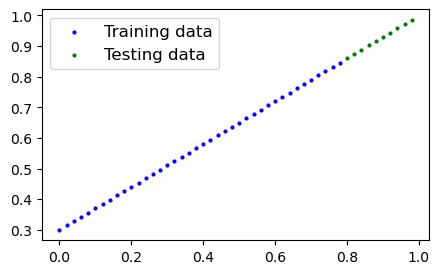

In [135]:
plot_predictions()

### 2. Building a model
take the blue dots and learn to get the green dots Y values right
Red dots -- on top of the green dots
Use linear regression model for NN

In [136]:
# create a linear regression model class (OOP)
class LinearRegressionModel(nn.Module):
    """ Use nn.Module
        nn.Mudule is the 'lego' bricks
        The model 
        1. will start from random parameters for : self.weights and self.bias
        2. update them to represent the test set data.
        
        The "learning" is done via an angorithm: 
        1. "Gradient Descent" (see requires_grad=True below)
        2. Back propagation
        Tracks the weights and bias graidents and updates them via grad. descent and back propagation
        
    """
    def __init__(self):
        super().__init__() # 
        # Initialize model parameters (anything, parameters, values, functions)
        self.weights = nn.Parameter(torch.randn(1, # random starting point
                                                requires_grad=True, # track graident 
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, # random starting point
                                            requires_grad=True, # track graident 
                                            dtype=torch.float))
    # Forward method to define the computation in the model (Required by nn.Module)
    def forward(self, x:torch.Tensor)->torch.Tensor: 
        """ Overrides the base class method.
            x: input
            THis is a linear regression formula.
            Same that was used to create the data
            Each time the class is called the 'forward' is called 
        """
        return self.weights * x + self.bias

### PyTorck model building essencials
* `torck.nn` - for computtational graphs, neutal networ is a computational graph
* `torch.nn.Parameter` - what should be learned. USually, PyTorch layer from `torch.nn` sets it
* `torch.nn.Module` - base class for all other NN modules. If subclassed, `forward` must be overriden
* `torch.optin` - optimizer, helps with grad. descend (optimizes weithgts and biases)
* `def forward()` - all nn.Module require this to be overriden. Defines the forward computation

### Checking the PyTorch model
Using `.parameters()`

In [137]:
# create a random seed
torch.manual_seed(42)
# create an instance of the model (subcalss of nn.Module)
model_0 = LinearRegressionModel()
list(model_0.parameters()) # random values obtained (same each time because of the fixed random seed)

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [138]:
# list named parameters `state_dict()`
print(model_0.state_dict())
# The goal is to get these state values closer to what explains the data

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


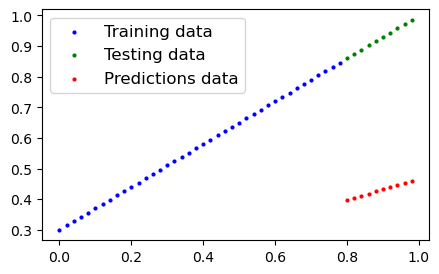

In [139]:
# Consider `torck.inference_model()` to make predictions
# Check the model's predictive power, predicting `y_test`, given `X_test`
# When data is given, it is passed through forward method
with torch.inference_mode(): # with `with` -- turn off the gradient tracking! Faster for inferences
    y_preds = model_0(X_test)
# This is equivalent to  but includes but tracks the gradient!
y_preds = model_0(X_test)
# this also dones not track 'grad' but also lacks something...
with torch.no_grad():
    y_preds = model_0(X_test)

y_preds
plot_predictions(predictions=y_preds)
# random initial weights and biases gave random result :)

# THis is eq

### Model training & evaluation model performace

Using loss function to evaluate model performace;  
Loss function (cost function or criterion):  
**Loss fucntion** a function to measure how wrong the model prediction. The lower the better.  
**Optimizer** takes into account loss and adjust the model parameters (weights, biases) `list(model.parameters())` or `model_0.state_dict()` to imporve the loss function (in PyTorch: via training loop, testing loop)

We consider `nn.L1Loss` or **mean absolute error (MAE)** creates a criterion=loss function, that measures MAE between each element and its actial value.

In [140]:
''' setup a loss function '''
loss_fn = nn.L1Loss()
# wee need t ominimize the distances between red and 
# green dots and MAE will also go down

''' SEtup an optimizer'''
# usually, Loss function and optimizer comes together in a package
# see torch.optim()
# optimizer 'talks' to the loss function and checks whether 
# changes improves loss function output
# e.g., SGD - stocahstic gradiant descend or Adam
# Model improves by taking random numbers 
# Once a step that minimises the loss function is found, it 
# will move in that direction to minimises further
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)
# lr = learning rate VERY IMPORTANT hyperparameter (set)
# Controls how much a parameter is adjusted after each 
# 'good' guess of the SGR (adjust a little but or a lot)

### Building a training loop and a testing loop
0. Loop through the data and do...
1. Forward pass (dat amoving from the input to the output layer) to make predicitons = (**forward propagation**)
2. Calculate the loss (compare forward pass predicitons to groud truth layer)
3. Optimizer zero grad
4. Loss backwards (moves back through network and compute gradients of each of the model parameters with respect to the loss) **back propagation**
5. Optimizer steps (use optimizer to adjust model parameters to change parameters/to improve the loss) (**gradient descend**) 

Optimizer compute a Loss-curve with all parameters on X axis and value of hte loss function on the y, and tries to find the minimum of this hypersurface. This refers to as gradient descent. 
Takes `model.params` and `lr` = learning rate, where the latter is a **stepsize** of the gradient descend. See also learning scheduling and convergence. 

Idea: if gradient of the loss equal zero, then the loss is equal zero


In [141]:
# show parameters (they require grad (as in default train))
with torch.inference_mode():
    print(list(model_0.parameters()))

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]


In [142]:
# assure that optimizer also has the same 'seed' (reproducability)
torch.manual_seed(42)

# an epoch is one loop through the data (epoch is hyperpar.)
epochs = 200

# Tracking experiment (values to track)
epoch_count = []
loss_vals = []
test_loss_vals = []

### TRAINING LOOP
# 0. loop through the data
for epoch in range(epochs):
    # Set model to training mode: (default training)
    # > All parameters that need grad. require grad now
    model_0.train()

    # 1. implement forward pass (forward function)
    # Learn partents on the train. data to eval. test data
    y_pred = model_0(X_train)

    # 2. Calculate the loss (MAE) in this case
    loss = loss_fn(y_pred, y_train) # (input,target)

    # 3. Optimizer 0-grad
    optimizer.zero_grad() #  Clear casch (for loss.bachwards() )

    # 4. Perform back propagation on the loss w/r model pars.
    # See youtube from 3Ble1Broun, 
    # Compute gradient of the loss func. with respect to model pars.
    # Find the minimum of the loss function (gradient extremum)
    loss.backward() # back propagation

    # 5. Step the optimizer (Perform gradient descend)
    # Optimizer cahnges accumulate through the loop 
    # (hast to be szeroed first in `zero_grad()`)
    # This is one of these 'frog leap' steps down the gradient curve
    optimizer.step() # gradient descend. always after loss.bachwards()


    # Testing Part Of the Loop.  
    # Evaluate model. turns off the gradient tracking;
    # dropout; BatchNorm...
    model_0.eval()
    with torch.inference_mode(): # turns off graient tracking, and others
        # No need to learn in testing...
        # 1. Forward pass in testing mode
        test_pred = model_0(X_test)
        
        # 2. Calcualte the loss
        test_loss = loss_fn(test_pred, y_test)

    
    # print the result
    if (epoch % 10 == 0):
        print(f"Epoch={epoch} | Loss: {loss} | test loss={test_loss}")
        print(model_0.state_dict())

        # save progess for future use
        epoch_count.append(epoch)
        loss_vals.append(loss)
        test_loss_vals.append(test_loss)



Epoch=0 | Loss: 0.31288138031959534 | test loss=0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch=10 | Loss: 0.1976713240146637 | test loss=0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch=20 | Loss: 0.08908725529909134 | test loss=0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch=30 | Loss: 0.053148526698350906 | test loss=0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch=40 | Loss: 0.04543796554207802 | test loss=0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch=50 | Loss: 0.04167863354086876 | test loss=0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch=60 | Loss: 0.03818932920694351 | test loss=0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
Epoch=70

In [143]:

# OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
model_0.state_dict() # original

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

We observe that each time rerunning the loop the bias and weights chage and the loss decreases. 
However, steps are random and the exact value of loss and model parameters differ every time you rerun the code. 

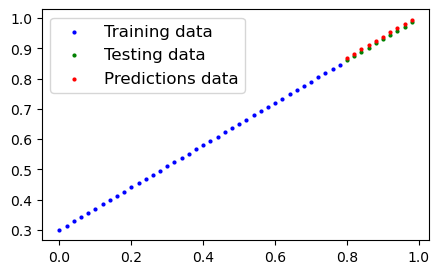

In [144]:
# predictions
with torch.inference_mode(): # with `with` -- turn off the gradient tracking! Faster for inferences
    y_preds_new = model_0(X_test)

# plot new predictions after N manual iterations
plot_predictions(predictions=y_preds_new)

We note that the predictions are closer to the expected values;
After a 100 epoch the values are much closer.  

After all the runs, the MAE (Mean average error) was significantly reduced to (loss=0.005ish)

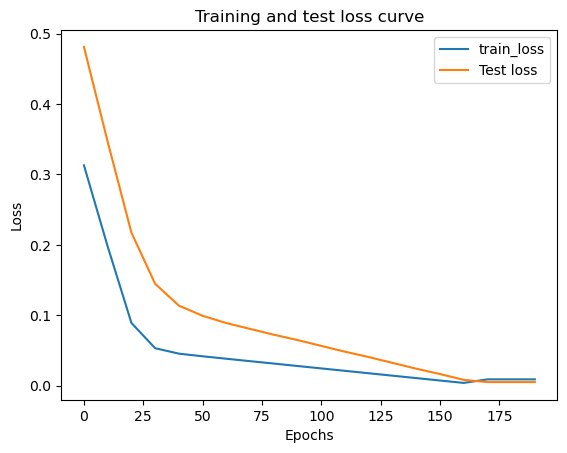

In [145]:
# plot loss cruve
plt.plot(epoch_count, torch.tensor(loss_vals).cpu().numpy(), label="train_loss")
plt.plot(epoch_count, torch.tensor(test_loss_vals).cpu().numpy(), label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


Declining loss curve is what supposed to happen. 
And at the end they match up. This may not happen. -- Problem. 

### Saving Model
Methods: for saving and loading
1. `torch.save()` - save a pytorch object in python pickle format (binary form of an python object)
2. `torch.load()` - load a saved pythorch object
3. `torch.nn.Module.load_state_dict()` load a model state dictionaly.
The last relies on the `model_0.state_dict()` that contains the model parameters. 
Depending on the need, various methods are better.

In [149]:
# Save and load
from pathlib import Path
# 1. create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model savepath
MODEL_NAME = "01_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

# 3. Save the model statedict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)
#torch.save(model_0)

models/01_pytorch_workflow_model_0.pt
Saving model to models/01_pytorch_workflow_model_0.pt


In [150]:
# Loading the model

# Create an empty instance of the model
loaded_model_0 = LinearRegressionModel()

# call on the model (from nn.Module) the load_state_dict
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Result says that loading was successfull 

In [153]:
# check predictions with the laoded model
loaded_model_0.eval() # set the eval mode
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

# run the predictions again (there was an error in matching...)
model_0.eval() # set the eval mode
with torch.inference_mode():
    model_preds = model_0(X_test)

# compare with original
model_preds == loaded_model_preds # This gives false !!!

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])